# Run Value Join Analysis

This notebook demonstrates and validates the improved run value joining logic.

In [1]:
import polars as pl
import statcast_pitches
from plotnine import *
import os

In [ ]:

def standardize_events(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Standardizes events to run_values.csv format"""
    event_mapping = {
        "single": "single",
        "double": "double",
        "triple": "triple",
        "home_run": "home_run",
        "field_out": "field_out",
        "strikeout": "strikeout",
        "walk": "walk",
        "hit_by_pitch": "hit_by_pitch"
    }

    description_mapping = {
        "called_strike": "called_strike",
        "swinging_strike": "swinging_strike",
        "ball": "ball",
        "foul": "foul",
        "hit_by_pitch": "hit_by_pitch"
    }
    return lf.with_columns([
        # First try to map the event
        pl.when(pl.col("events").is_in(event_mapping.keys()))
        .then(pl.col("events"))
        # If no event match, try to map the description
        .otherwise(
            pl.when(pl.col("description").is_in(description_mapping.keys()))
            .then(pl.col("description"))
            # If neither matches, mark as null
            .otherwise(None)
        ).alias("standardized_event")
    ])

def add_pitch_run_value(pitches_lf: pl.LazyFrame, run_values_lf: pl.LazyFrame) -> pl.LazyFrame:
    """
    Join run values to pitches using standardized event names and count states
    
    Parameters:
    -----------
    pitches_lf : pl.LazyFrame
        LazyFrame containing pitch data
    run_values_lf : pl.LazyFrame
        LazyFrame containing run value data
        
    Returns:
    --------
    pl.LazyFrame
        Original pitches with run values joined
    """

    def join_run_values(df: pl.LazyFrame) -> pl.LazyFrame:
        return (df
                .join(
                    other=run_values_lf,
                    left_on=["standardized_event", "balls", "strikes"],
                    right_on=["event", "balls", "strikes"],
                    how="left",
                )
                # Handle missing run values
                .with_columns([
                    pl.when(pl.col("delta_run_exp").is_null())
                    .then(0.0)  # Default to 0 run value for unknown events
                    .otherwise(pl.col("delta_run_exp"))
                    .alias("delta_run_exp")
                ]))

    return (pitches_lf
            .pipe(standardize_events)
            .pipe(join_run_values))


def calculate_sequence_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """
    Calculate the total run value for a two-pitch sequence
    """
    return lf.with_columns([
        (pl.col("delta_run_exp") + pl.col("prev_delta_run_exp"))
        .alias("seq_delta_run_exp")
    ])

## Load Data

Loading both the pitch data and run values data

In [6]:
# Load pitches data
pitches_lf = (statcast_pitches.load()
              .filter(pl.col("game_date").dt.year().is_in([2020, 2021, 2022, 2023])))

# Load run values
run_values_lf = pl.scan_csv(os.path.join("..", "data", "run_values.csv"))

## Join Run Values

Using the improved joining logic to add run values to each pitch

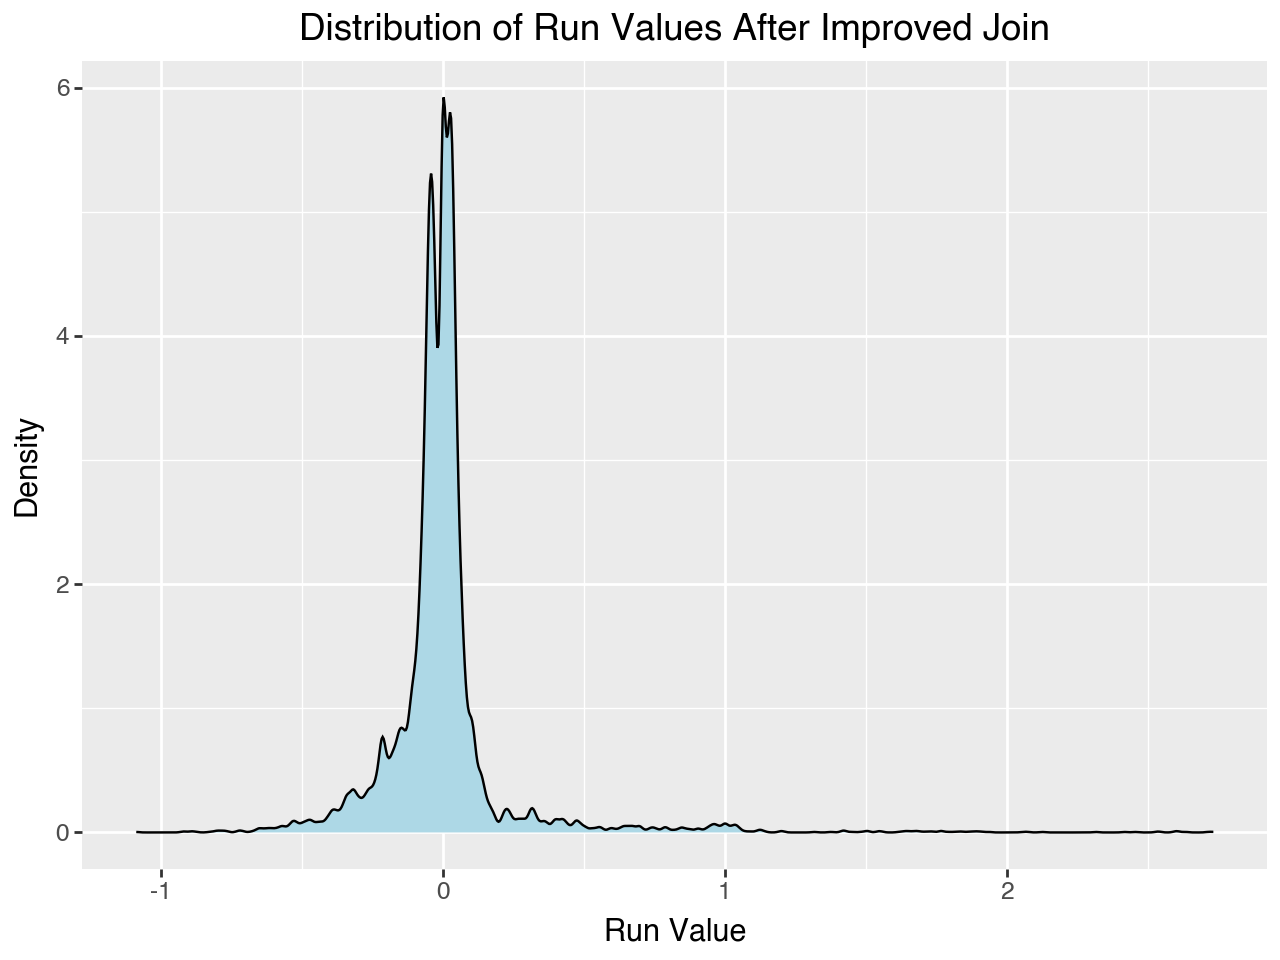

In [7]:
# Join run values to pitches
pitches_with_rv = pitches_lf.pipe(add_pitch_run_value, run_values_lf)

# Examine the distribution of run values
rv_dist = (
    ggplot(
        pitches_with_rv.select("delta_run_exp", "standardized_event")
        .collect()
        .sample(n=10000),
        aes(x="delta_run_exp")
    )
    + geom_density(fill="lightblue")
    + labs(
        title="Distribution of Run Values After Improved Join",
        x="Run Value",
        y="Density"
    )
)

rv_dist.show()

## Analyze Join Quality

Examining the quality of the join by looking at match rates and distributions

In [10]:
# Analyze join statistics
join_stats = (
    pitches_with_rv
    .group_by("standardized_event")
    .agg([
        pl.count().alias("count"),
        pl.col("delta_run_exp").mean().alias("mean_run_value"),
        pl.col("delta_run_exp").std().alias("std_run_value")
    ])
    .sort("count", descending=True)
    .collect()
)

print("\nJoin Statistics by Event Type:")
join_stats

/var/folders/2_/kwjd2wv14q91l3mg7r83n04c0000gn/T/ipykernel_19657/2602325515.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.



Join Statistics by Event Type:


standardized_event,count,mean_run_value,std_run_value
str,u32,f64,f64
"""ball""",808555,0.04406,0.038135
"""foul""",451302,-0.03451,0.040809
"""called_strike""",387943,-0.047816,0.03242
"""field_out""",266259,-0.220578,0.140723
"""swinging_strike""",185587,-0.052964,0.040733
…,…,…,…
"""walk""",56229,0.210268,0.146105
"""double""",29830,0.70638,0.468988
"""home_run""",21399,1.278182,0.632333


## Calculate Sequence Run Values

Now calculating run values for two-pitch sequences

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 325 rows containing non-finite values.


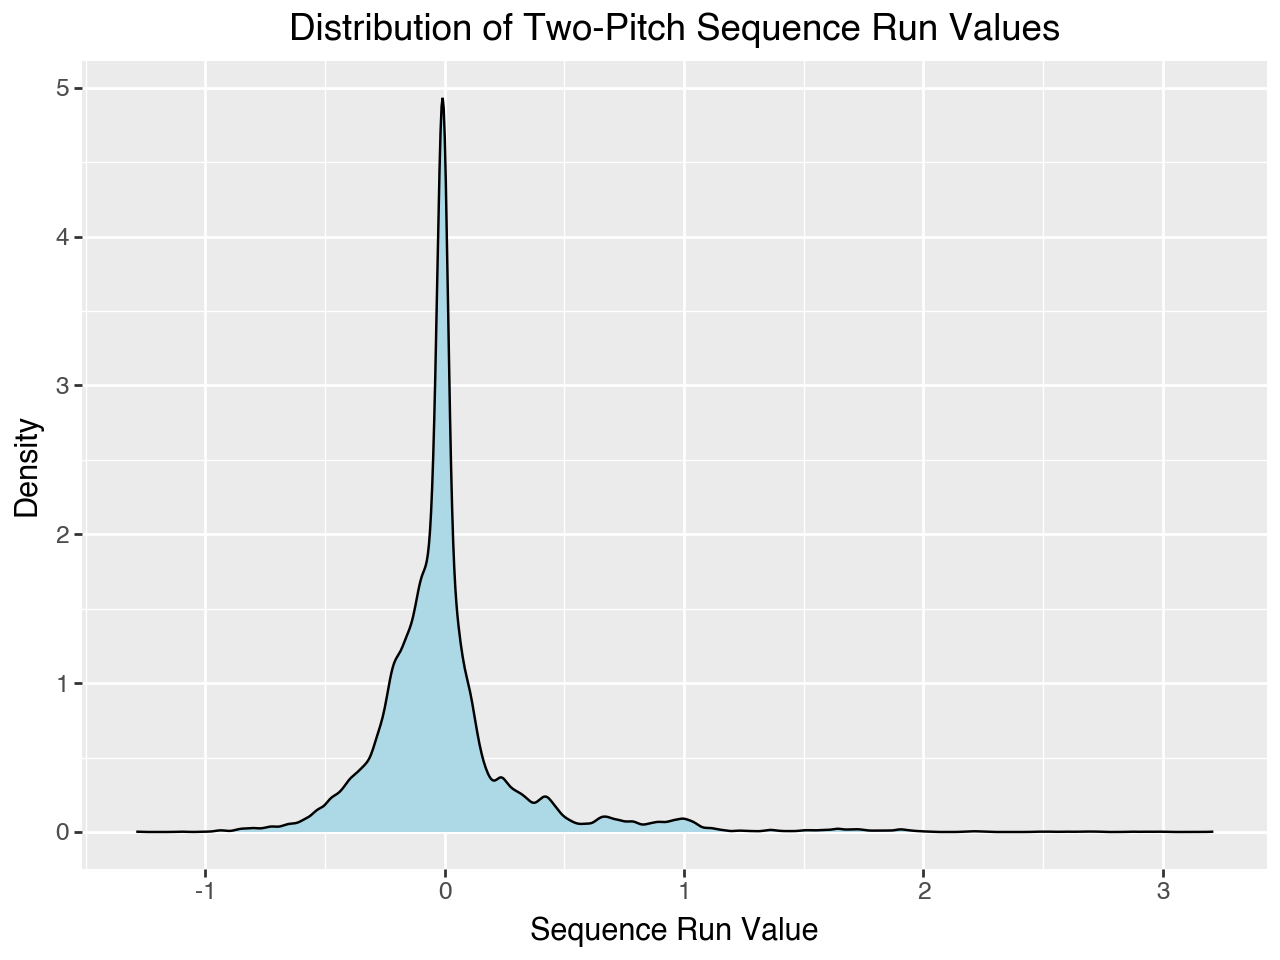

In [11]:
# Sort pitches for proper sequencing
sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
sorted_pitches = pitches_with_rv.sort(sort_cols)

# Add previous pitch features
sequence_features = [
    "delta_run_exp",
    "standardized_event",
    "pitch_type"
]

sequence_pitches = (
    sorted_pitches
    .with_columns([
        pl.col(feature)
        .shift(-1)
        .over(["pitcher", "at_bat_number"])
        .alias(f"prev_{feature}")
        for feature in sequence_features
    ])
)

# Calculate sequence run values
sequence_rv = sequence_pitches.pipe(calculate_sequence_run_value)

# Plot sequence run value distribution
seq_rv_dist = (
    ggplot(
        sequence_rv
        .select("seq_delta_run_exp")
        .collect()
        .sample(n=10000),
        aes(x="seq_delta_run_exp")
    )
    + geom_density(fill="lightblue")
    + labs(
        title="Distribution of Two-Pitch Sequence Run Values",
        x="Sequence Run Value",
        y="Density"
    )
)

seq_rv_dist.show()

## Analyze Most Valuable Sequences

Looking at which pitch type combinations produce the highest/lowest run values

In [14]:
# Analyze pitch type combinations
pitch_combos = (
    sequence_rv
    .group_by(["pitch_type", "prev_pitch_type"])
    .agg([
        pl.count().alias("count"),
        pl.col("seq_delta_run_exp").mean().alias("mean_sequence_rv"),
        pl.col("seq_delta_run_exp").std().alias("std_sequence_rv")
    ])
    .filter(pl.col("count") >= 100)  # Filter for common combinations
    .sort("mean_sequence_rv", descending=True)
    .collect()
)

print("\nMost Effective Pitch Combinations:")
pitch_combos.head(10)

/var/folders/2_/kwjd2wv14q91l3mg7r83n04c0000gn/T/ipykernel_19657/4101695230.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.



Most Effective Pitch Combinations:


pitch_type,prev_pitch_type,count,mean_sequence_rv,std_sequence_rv
str,str,u32,f64,f64
"""FA""",null,850,null,null
"""FA""","""EP""",199,0.091658,0.492711
"""FA""","""FA""",2188,0.06145,0.453444
"""CS""","""FF""",136,0.049963,0.307984
"""EP""","""FA""",194,0.047361,0.363008
"""FC""",null,6265,0.039592,0.531322
"""EP""","""EP""",652,0.038353,0.42269
"""ST""",null,3222,0.036347,0.514256
"""FF""",null,30160,0.035627,0.47155
